In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch 
import numpy as np
import ase 
from ase.io import read
import json  
from ase.units import Hartree

In [3]:
torch.set_default_dtype(torch.float64) # set default dtype of torch to avoid numerical errors 

In [4]:
device = "cpu"

# Instantiate the Molecule Dataset 

In [5]:
from mlelec.data.dataset import MoleculeDataset

/home/suman/miniconda3/envs/pyscfad/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [6]:
molecule_data = MoleculeDataset(
    mol_name = "ethane",
    use_precomputed=True,
    path= "examples/data/ethane",
    aux_path="examples/data/ethane/sto-3g",
    frame_slice=slice(0, 200),
    device=device,
    aux=["overlap", "orbitals"],
    target=["fock", "dipole_moment"],
)


Loading structures
examples/data/ethane/sto-3g/fock.hickle
examples/data/ethane/sto-3g/dipole_moment.hickle


### Create the ML dataset from the molecular data 

In [7]:
from mlelec.data.dataset import MLDataset

In [8]:
ml_data = MLDataset(
    molecule_data=molecule_data,
    device=device,
    model_strategy="coupled",
    shuffle=True, 
    shuffle_seed=5380,
)  

In [9]:
ml_data._split_indices(train_frac=0.7, val_frac=0.2, test_frac=0.1)

In [10]:
from mlelec.features.acdc import compute_features_for_target
from mlelec.data.dataset import get_dataloader

In [11]:
hypers = {
            "cutoff": 5.0,
            "max_radial" : 6,
            "max_angular": 4,
            "atomic_gaussian_width": 0.3,
            "center_atom_weight": 1,
            "radial_basis": {"Gto": {}},
            "cutoff_function": {"ShiftedCosine": {"width": 0.1}},
        }

ml_data._set_features(compute_features_for_target(ml_data, device = device, hypers = hypers))

In [12]:
train_dl, val_dl, test_dl = get_dataloader(ml_data, model_return="tensor", batch_size=10)

# RidgeCV Model

In [13]:
from src.mlelec.models.linear import LinearTargetModel

### Fitting a RidgeCV model

In [14]:
model = LinearTargetModel(dataset = ml_data, nlayers = 1, nhidden = 16, bias = False, device = device)

In [15]:
pred_ridges, ridges = model.fit_ridge_analytical(set_bias=False)

### Calculating train and test errors for MO energies and dipoles

In [20]:
from mlelec.utils.twocenter_utils import _to_uncoupled_basis, _to_matrix, unfix_orbital_order
    
uncoupled = _to_uncoupled_basis(pred_ridges,  device=model.device) # Convert the coupled blocks to uncoupled

# Recover the predicted matrices for the training set 
fock_predictions_train = _to_matrix(
    uncoupled,
    ml_data.train_frames,
    ml_data.train_idx,
    ml_data.aux_data['orbitals'],
    device=model.device,
)

In [22]:
from typing import Optional, List, Union, Tuple, Dict

def isqrtm(A: torch.Tensor) -> torch.Tensor:
    eva, eve = torch.linalg.eigh(A)
    idx = eva > 1e-15
    return eve[:, idx] @ torch.diag(eva[idx] ** (-0.5)) @ eve[:, idx].T


def _lowdin_orthogonalize(
    fock: torch.Tensor, ovlp: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor]:
    ovlp_i12 = isqrtm(ovlp)
    return torch.einsum("ij,jk,kl->il", ovlp_i12, fock, ovlp_i12)

In [24]:
# from mlelec.utils.twocenter_utils import _lowdin_orthogonalize

def compute_eigvals(ml_data, focks, indices):
    batch_frames = [ml_data.structures[i] for i in indices]
    batch_fock = unfix_orbital_order(
        focks, batch_frames, ml_data.molecule_data.aux_data["orbitals"]
    )
    batch_overlap = ml_data.molecule_data.aux_data["overlap"][indices]
    ortho_focks = [_lowdin_orthogonalize(f, o) for f, o in zip(batch_fock, batch_overlap)]
    eva = []
    for i in range(len(focks)):
        eva.append(torch.linalg.eigvalsh(ortho_focks[i]))
    return torch.stack(eva)

In [28]:
pred_eva = compute_eigvals(ml_data, fock_predictions_train, ml_data.train_idx)
eva = compute_eigvals(ml_data, ml_data.target.tensor[ml_data.train_idx], ml_data.train_idx)

In [35]:
import mlelec.metrics as mlmetrics

loss_fn = getattr(mlmetrics, "L2_loss")
print("Train RMSE for MO_energies in eV: ", torch.sqrt(loss_fn(pred_eva, eva) / len(ml_data.train_idx) /16) *Hartree)

Train RMSE for MO_energies in eV:  tensor(0.9846)


In [36]:
pred_test = model.predict_ridge_analytical(ml_data.target_test, ml_data.feat_test)

In [37]:
test_uncoupled = _to_uncoupled_basis(pred_test,  device=model.device) # Convert the coupled blocks to uncoupled
fock_predictions_test = _to_matrix(
test_uncoupled,
    ml_data.test_frames,
    ml_data.test_idx,
    ml_data.aux_data['orbitals'],
    device=model.device,
)

In [40]:
test_pred_eva = compute_eigvals(ml_data, fock_predictions_test, ml_data.test_idx)
test_eva = compute_eigvals(ml_data, ml_data.target.tensor[ml_data.test_idx], ml_data.test_idx)

print("Test RMSE for MO_energies in eV: ", torch.sqrt(loss_fn(test_pred_eva, test_eva) / len(ml_data.test_idx) /16) *Hartree)

Test RMSE for MO_energies in eV:  tensor(0.9743)


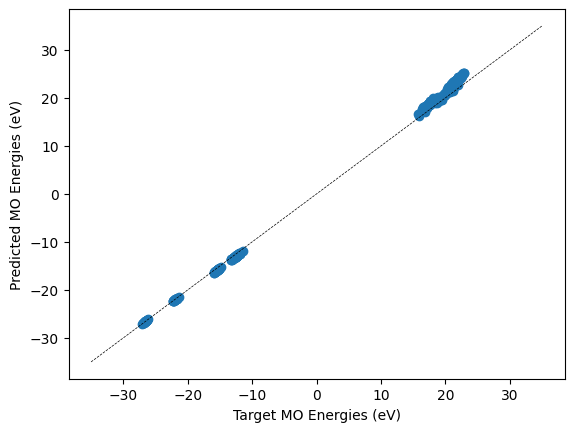

In [41]:
import matplotlib.pyplot as plt

x = test_eva * Hartree
y = test_pred_eva * Hartree

x = x[x>-50]
y = y[y>-50]
plt.scatter(x,y)

plt.plot([-35,35], [-35,35], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target MO Energies (eV)')
plt.ylabel('Predicted MO Energies (eV)')
plt.show()

## Indirect learning of eigenvalues via bacprop

In [43]:
import os
os.environ["PYSCFAD_BACKEND"] = "torch"
import torch
from torch.autograd.functional import jacobian
from pyscf import gto
from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order
from tqdm import tqdm

Using PyTorch backend.


In [33]:
# with io.capture_output() as captured:
#     all_mfs, fockvars = instantiate_mf(
#         ml_data,
#         fock_predictions=None,
#         batch_indices=list(range(len(ml_data.structures))),
#     )

In [44]:
from cmath import inf
best = inf
early_stop_criteria = 50

In [ ]:
# Do this only if you want to start your indirect training from the Ridge fitted weights
train_pred = model.forward(ml_data.feat_train, return_type="tensor", batch_indices=ml_data.train_idx, ridge_fit=True)

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=20, verbose=True
)

val_interval = 10
loss_fn = getattr(mlmetrics, "L2_loss") 
losses = []
early_stop_count = 0
nepochs = 800

In [54]:
iterator = tqdm(range(nepochs))

for epoch in iterator:
    model.train(True)
    train_loss = 0
    for data in train_dl:
        optimizer.zero_grad()
        idx = data["idx"]

        #forward pass
        pred = model(data["input"], return_type="tensor", batch_indices=idx)
        pred_evals = compute_eigvals(ml_data, pred, data["idx"])
        targ_evals = compute_eigvals(ml_data, ml_data.target.tensor[idx], data["idx"])
        
        loss = loss_fn(pred_evals, targ_evals)
        # train_dip_pred = compute_batch_dipole_moment(
        #     ml_data, pred, batch_indices=idx, mfs=all_mfs
        # )
        # dip = torch.from_numpy(ml_data.molecule_data.target["dipole_moment"][idx].astype(np.float64))
        
        # loss = loss_fn(train_dip_pred, dip)
        train_loss += loss.item()
        
        # backward pass
        loss.backward()
        optimizer.step()

    losses.append(train_loss)
    scheduler.step(train_loss)
    
    model.train(False)

    if epoch % val_interval == 0:
        val_loss = 0
        for i, data in enumerate(val_dl):
            idx = data["idx"]
            val_pred = model(data["input"], return_type="tensor", batch_indices=idx)
            val_pred_eval = compute_eigvals(ml_data, val_pred, data["idx"])
            val_targ_eval = compute_eigvals(ml_data, ml_data.target.tensor[idx], data["idx"])
            vloss = loss_fn(val_pred_eval, val_targ_eval)
            
            # with io.capture_output() as captured:
            #     val_dip_pred = compute_batch_dipole_moment(
            #         ml_data, val_pred, batch_indices=idx, mfs=all_mfs
            #     )
            # val_dip = torch.from_numpy(ml_data.molecule_data.target["dipole_moment"][idx].astype(np.float64))
            # vloss = loss_fn(val_dip_pred, val_dip)
            val_loss += vloss.item()
        new_best = val_loss < best
        if new_best:
            best = val_loss
            # torch.save(model.state_dict(), 'best_model_dipole.pt')
            early_stop_count = 0
        else:
            early_stop_count += 1
        if early_stop_count > early_stop_criteria:
            print(f"Early stopping at epoch {epoch}")
            print(f"Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}")

            print(f"Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}")
            # Save last best model
            break

    if epoch % 1 == 0:
        iterator.set_postfix(train_loss = train_loss/len(ml_data.train_idx), Val_loss = val_loss/len(ml_data.val_idx))

  8%|▊         | 67/800 [05:55<1:04:44,  5.30s/it, Val_loss=0.0003, train_loss=0.000184]  


KeyboardInterrupt: 

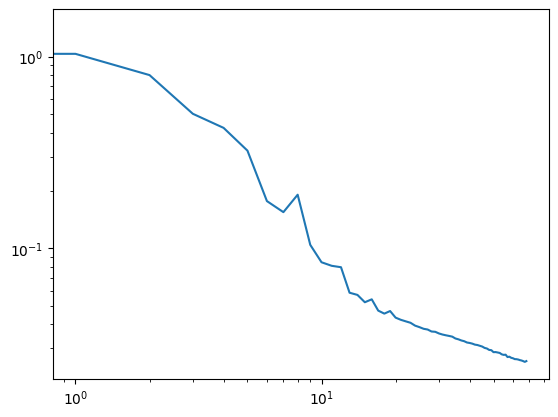

In [55]:
from matplotlib import pyplot as plt
plt.loglog(losses)

In [57]:
with io.capture_output() as captured:
    test_fock_predictions = model.forward(
        ml_data.feat_test, return_type="tensor", ml_data.test_idx,
    )

In [ ]:
test_eva_pred_ind = compute_eigvals(ml_data, test_fock_predictions, ml_data.test_idx)
test_eva_ref = compute_eigvals(ml_data, ml_data.target.tensor[ml_data.test_idx], ml_data.test_idx)

In [74]:
error = loss_fn(test_eva_pred_ind, test_eva_ref) / len(ml_data.test_idx)
error

tensor(0.0004, grad_fn=<DivBackward0>)

In [77]:
print("Test RMSE on MO energies after indirect learning on eigenvalues {:.5f} eV ".format(torch.sqrt(error/16)*Hartree))

Test RMSE on MO energies after indirect learning on dipoles 0.13131 eV 


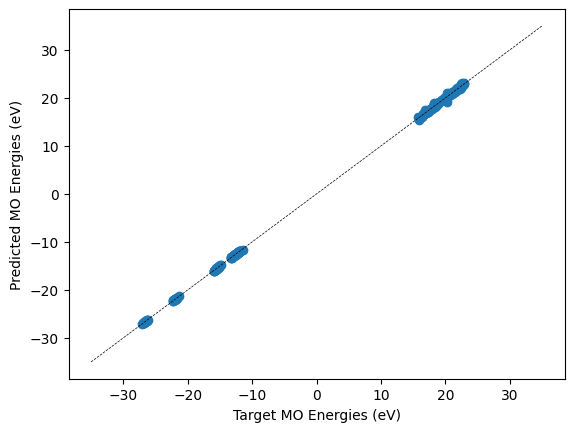

In [65]:
x = test_eva_ref.detach().numpy()  * Hartree
y = test_eva_pred_ind.detach().numpy()  * Hartree

x = x[x>-50]
y = y[y>-50]
plt.scatter(x,y)
    
plt.plot([-35,35], [-35,35], linestyle='--', color='black', linewidth=0.5)
plt.xlabel('Target MO Energies (eV)')
plt.ylabel('Predicted MO Energies (eV)')
plt.show()